In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = depthwiseseparableconv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_2 = depthwiseseparableconv2DBatchNormRelu(
            16, 32, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_3 = depthwiseseparableconv2DBatchNormRelu(
            32, 64, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(1024, 512)
        self.fc_2 = nn.Linear(512, 3)
        
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout1d(p=0.2, inplace=False)
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.maxpool2d(self.cbr_2(x))
        x = self.maxpool2d(self.cbr_3(x))
        
        #全結合層
        x = self.sigmoid(self.fc_1(self.flatten(x)))
        x = self.fc_2(self.dropout(x))
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                             Output Shape              Param #
Model                                              [64, 3]                   --
├─depthwiseseparableconv2DBatchNormRelu: 1-1       [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                                 [64, 3, 32, 32]           84
│    └─BatchNorm2d: 2-2                            [64, 3, 32, 32]           6
│    └─ReLU: 2-3                                   [64, 3, 32, 32]           --
│    └─Conv2d: 2-4                                 [64, 16, 32, 32]          64
│    └─BatchNorm2d: 2-5                            [64, 16, 32, 32]          32
│    └─ReLU: 2-6                                   [64, 16, 32, 32]          --
│    └─Dropout2d: 2-7                              [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                                   [64, 16, 16, 16]          --
├─depthwiseseparableconv2DBatchNormRelu: 1-3       [64, 32, 16, 16]          --
│    └─Conv2d: 2-8                  

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=50
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.98it/s]


val Loss: 1.1722 Acc: 0.3333
Epoch 2/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.11it/s]


train Loss: 1.4118 Acc: 0.3634


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.06it/s]


val Loss: 1.2552 Acc: 0.3333
Epoch 3/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.79it/s]


train Loss: 1.0557 Acc: 0.4364


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.08it/s]


val Loss: 1.2761 Acc: 0.3333
Epoch 4/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


train Loss: 1.0296 Acc: 0.4715


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.92it/s]


val Loss: 0.8546 Acc: 0.6643
Epoch 5/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.9814 Acc: 0.5065


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.97it/s]


val Loss: 0.8872 Acc: 0.6133
Epoch 6/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.9359 Acc: 0.5566


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.92it/s]


val Loss: 0.8328 Acc: 0.6267
Epoch 7/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


train Loss: 0.8996 Acc: 0.5606


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.94it/s]


val Loss: 0.8059 Acc: 0.6771
Epoch 8/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.8967 Acc: 0.5776


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.97it/s]


val Loss: 0.8848 Acc: 0.5648
Epoch 9/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.8653 Acc: 0.6056


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.89it/s]


val Loss: 1.0060 Acc: 0.4505
Epoch 10/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.8642 Acc: 0.6126


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.92it/s]


val Loss: 0.9629 Acc: 0.5976
Epoch 11/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.8589 Acc: 0.6146


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.92it/s]


val Loss: 0.7727 Acc: 0.6686
Epoch 12/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.8358 Acc: 0.6186


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.89it/s]


val Loss: 0.7935 Acc: 0.6700
Epoch 13/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.8153 Acc: 0.6206


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.91it/s]


val Loss: 0.7856 Acc: 0.6871
Epoch 14/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.8021 Acc: 0.6256


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.95it/s]


val Loss: 0.8940 Acc: 0.6257
Epoch 15/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.05it/s]


train Loss: 0.8210 Acc: 0.6146


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.96it/s]


val Loss: 0.8520 Acc: 0.6043
Epoch 16/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.7746 Acc: 0.6717


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.94it/s]


val Loss: 0.7413 Acc: 0.7019
Epoch 17/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.7724 Acc: 0.6426


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.87it/s]


val Loss: 0.7887 Acc: 0.6571
Epoch 18/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.7808 Acc: 0.6486


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.96it/s]


val Loss: 0.7410 Acc: 0.6933
Epoch 19/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


train Loss: 0.7600 Acc: 0.6567


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.75it/s]


val Loss: 0.7578 Acc: 0.6762
Epoch 20/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.7705 Acc: 0.6597


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.40it/s]


val Loss: 0.7373 Acc: 0.6910
Epoch 21/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.7391 Acc: 0.6737


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.63it/s]


val Loss: 0.7842 Acc: 0.6619
Epoch 22/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.7521 Acc: 0.6557


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.77it/s]


val Loss: 0.9430 Acc: 0.5857
Epoch 23/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


train Loss: 0.7258 Acc: 0.6767


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.70it/s]


val Loss: 0.7969 Acc: 0.6629
Epoch 24/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


train Loss: 0.6951 Acc: 0.6987


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.56it/s]


val Loss: 0.7710 Acc: 0.6724
Epoch 25/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


train Loss: 0.7029 Acc: 0.6997


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.73it/s]


val Loss: 0.7940 Acc: 0.6724
Epoch 26/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.00it/s]


train Loss: 0.6866 Acc: 0.6877


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.67it/s]


val Loss: 0.8227 Acc: 0.6586
Epoch 27/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.6692 Acc: 0.6947


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.93it/s]


val Loss: 1.0774 Acc: 0.6005
Epoch 28/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.98it/s]


train Loss: 0.6948 Acc: 0.6867


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.96it/s]


val Loss: 0.9897 Acc: 0.6038
Epoch 29/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.6881 Acc: 0.6907


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.96it/s]


val Loss: 0.7772 Acc: 0.6962
Epoch 30/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.04it/s]


train Loss: 0.6524 Acc: 0.7007


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.84it/s]


val Loss: 0.7466 Acc: 0.7048
Epoch 31/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.68it/s]


train Loss: 0.6619 Acc: 0.6987


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.95it/s]


val Loss: 0.7733 Acc: 0.6833
Epoch 32/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


train Loss: 0.6245 Acc: 0.7137


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.94it/s]


val Loss: 0.9792 Acc: 0.6171
Epoch 33/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


train Loss: 0.6462 Acc: 0.7107


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.90it/s]


val Loss: 0.7767 Acc: 0.6829
Epoch 34/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


train Loss: 0.6719 Acc: 0.6947


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.88it/s]


val Loss: 0.7843 Acc: 0.7052
Epoch 35/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


train Loss: 0.6497 Acc: 0.7157


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.72it/s]


val Loss: 0.9495 Acc: 0.6414
Epoch 36/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


train Loss: 0.6377 Acc: 0.7027


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.90it/s]


val Loss: 0.8973 Acc: 0.6324
Epoch 37/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.6099 Acc: 0.6947


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.86it/s]


val Loss: 0.8695 Acc: 0.6610
Epoch 38/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


train Loss: 0.6228 Acc: 0.7167


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.94it/s]


val Loss: 0.7935 Acc: 0.6805
Epoch 39/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.5969 Acc: 0.7227


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.91it/s]


val Loss: 0.7843 Acc: 0.7043
Epoch 40/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.94it/s]


train Loss: 0.6216 Acc: 0.7027


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.82it/s]


val Loss: 0.8205 Acc: 0.7010
Epoch 41/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.6209 Acc: 0.7037


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.94it/s]


val Loss: 0.7796 Acc: 0.7300
Epoch 42/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.89it/s]


train Loss: 0.5556 Acc: 0.7357


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.90it/s]


val Loss: 0.8461 Acc: 0.6624
Epoch 43/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.5959 Acc: 0.7197


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.95it/s]


val Loss: 0.8278 Acc: 0.6871
Epoch 44/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.5549 Acc: 0.7367


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.97it/s]


val Loss: 0.8622 Acc: 0.6705
Epoch 45/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.5990 Acc: 0.7217


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.95it/s]


val Loss: 0.9462 Acc: 0.6443
Epoch 46/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.5479 Acc: 0.7548


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.93it/s]


val Loss: 0.9030 Acc: 0.6419
Epoch 47/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.5521 Acc: 0.7307


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.92it/s]


val Loss: 1.0918 Acc: 0.6310
Epoch 48/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.02it/s]


train Loss: 0.5962 Acc: 0.7337


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.96it/s]


val Loss: 0.7882 Acc: 0.6967
Epoch 49/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.5881 Acc: 0.7207


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.89it/s]


val Loss: 0.8385 Acc: 0.6814
Epoch 50/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.08it/s]


train Loss: 0.5513 Acc: 0.7307


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.93it/s]

val Loss: 0.9705 Acc: 0.6381


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

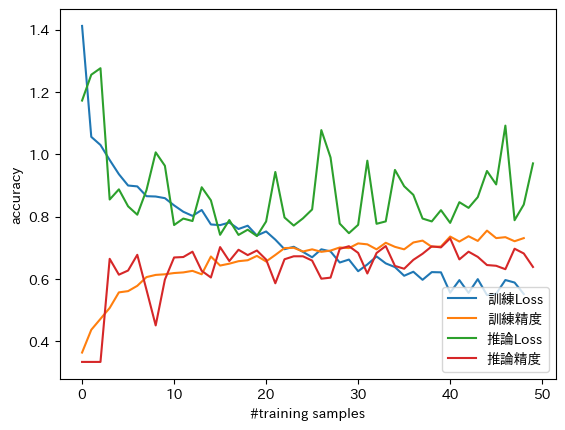

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

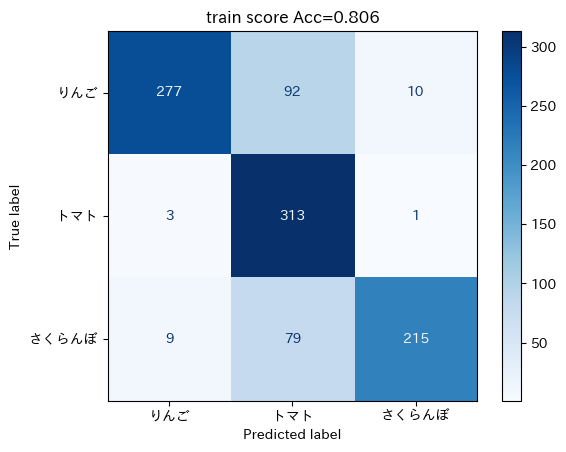

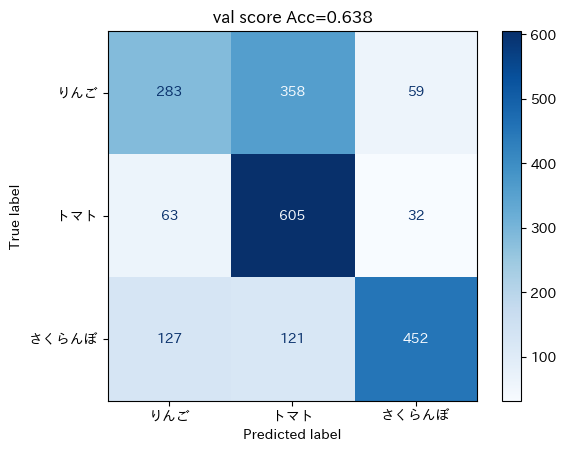

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

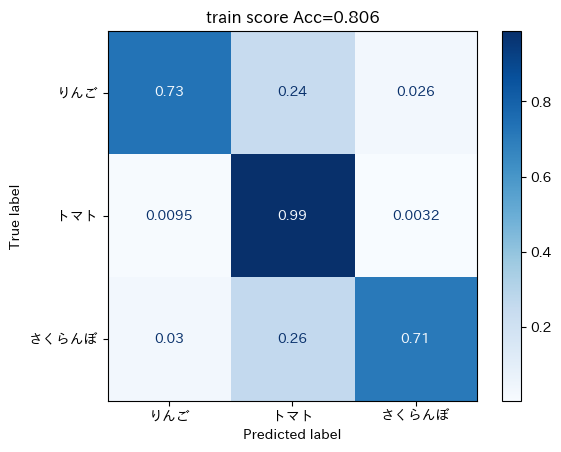

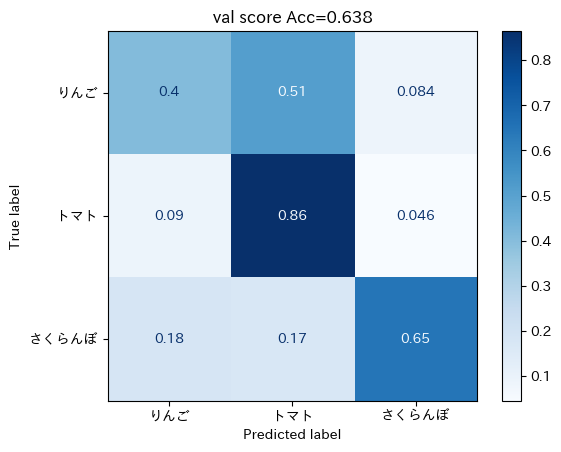

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()